## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [151]:
import pandas as pd
import seaborn as sns
import datetime, warnings, scipy
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [152]:
df = pd.read_csv('../merge_df.csv')
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [153]:
df.shape

(40101, 22)

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [154]:
from scipy import stats

In [155]:
stats.normaltest(df.arr_delay)

NormaltestResult(statistic=6648.83114789942, pvalue=0.0)

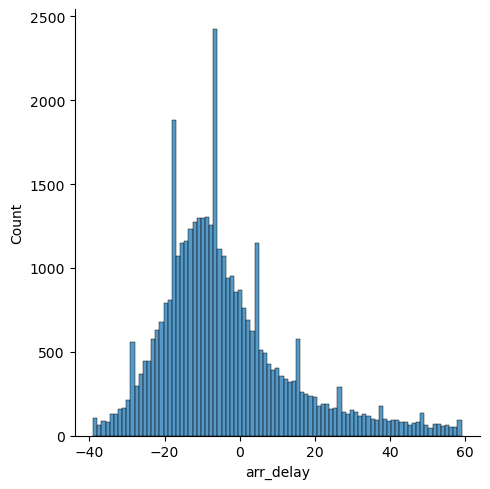

In [156]:
sns.displot(df.arr_delay)
plt.show()

Per the tests and chart above our sample is not from a normal distribution and the mean is not 0<br>
------------------------------------------------

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [157]:
delays = df[df['arr_delay'] > 0]

In [450]:
avg_delay_month = df.groupby('month', as_index=False).agg('arr_delay').mean()

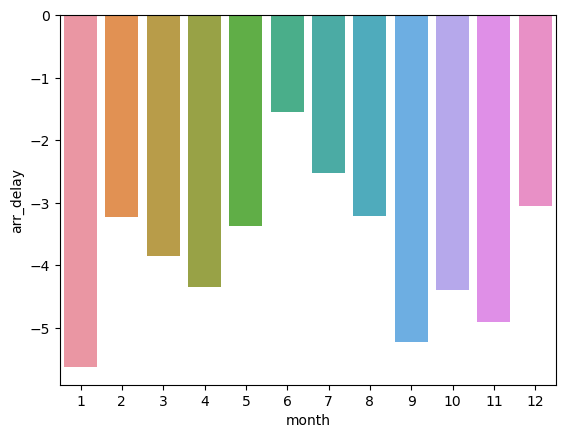

In [451]:
sns.barplot(x=avg_delay_month.month, y=avg_delay_month.arr_delay)
plt.show()

#### Seems to be and increase during the summer months
#### Will assume this is due to summer vacations, kids are out school, overall a nicer time to travel for leasure.
----------------
-----------

## **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [391]:
df.groupby('origin').size().sort_values(ascending=False)[:5]

origin
Chicago, IL        2381
Atlanta, GA        2329
Denver, CO         1531
Los Angeles, CA    1445
New York, NY       1342
dtype: int64

In [444]:
chicago_weather = pd.read_csv('chicago_2019_weather.csv')
chicago_weather.drop(columns=chicago_weather.columns[0], axis=1, inplace=True)

In [445]:
chicago = df[df['origin'] == 'Chicago, IL'] 
# chicago = chicago[chicago['arr_delay'] > 0]

In [446]:
weather_df = chicago.merge(right=chicago_weather, how='inner')

In [447]:
weather_df = weather_df[['fl_date', 'arr_delay', 'weather']]

In [448]:
weather_df = weather_df.groupby('weather', as_index=False).agg('arr_delay').mean()

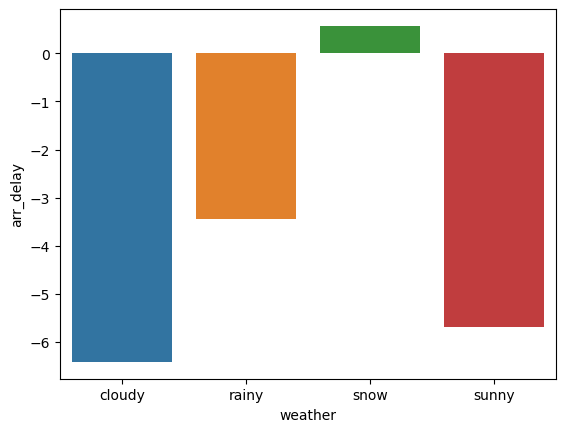

In [449]:
sns.barplot(x=weather_df.weather, y=weather_df.arr_delay)
plt.show()

### **Task 4**: How are taxi times changing during the day? Does higher traffic lead to bigger taxi times?

---------
Traffic (number of flights at that time)

In [160]:
df['crs_dep_time'] = pd.qcut(df['crs_dep_time'], 24, labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
traffic = df.groupby('crs_dep_time', as_index=False).size()
taxi_times = df.groupby('crs_dep_time', as_index=False).agg('taxi_out').mean()

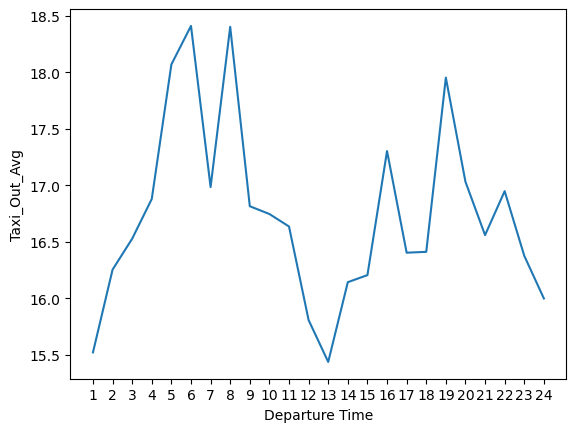

In [162]:
sns.lineplot(x=taxi_times.crs_dep_time, y=taxi_times.taxi_out)
plt.xlabel('Departure Time')
plt.ylabel('Taxi_Out_Avg')
plt.xticks(taxi_times.crs_dep_time)
plt.show()

In [163]:
# taxi_traffic_df = taxi_times.merge(right=traffic, how='inner')
# taxi_traffic_df.rename(columns={'size': 'traffic'}, inplace=True)

In [164]:
traffic_by_day = df.groupby('day_of_week', as_index=False).size()
taxi_by_day = df.groupby('day_of_week', as_index=False).agg('taxi_out').mean()
taxi_traffic_day = taxi_by_day.merge(right=traffic_by_day, how='inner')
taxi_traffic_day.rename(columns={'size': 'traffic'}, inplace=True)

In [165]:
# taxi_traffic_day['traffic'] = pd.qcut(taxi_traffic_day.traffic, 4, labels=[1,2,3,4])

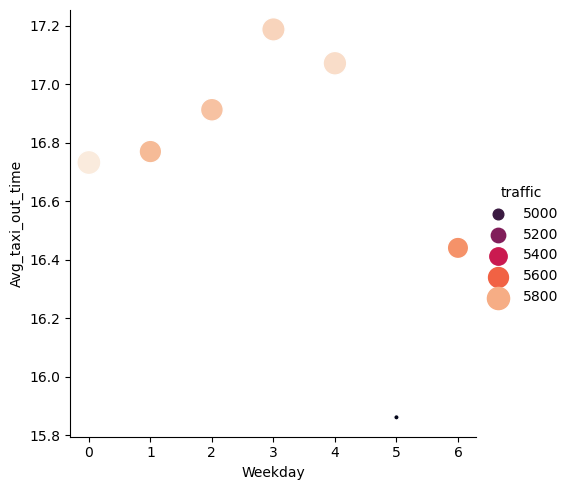

In [166]:
sns.relplot(
    data=taxi_traffic_day, x="day_of_week", y="taxi_out",
    size="traffic", sizes=(15, 300), hue='traffic', palette="rocket"
)

plt.xlabel('Weekday')
plt.ylabel('Avg_taxi_out_time')
# sns.color_palette("hls", 8)

plt.show()

In [167]:
# taxi_times.index = pd.qcut(taxi_times.index, 24, labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

### **Task 5**: What is the average percentage of delays that is created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

-------------
Departure delay percentage

In [168]:
df.columns

Index(['fl_date', 'mkt_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'carrier', 'origin', 'destination', 'distance', 'crs_dep_time',
       'crs_arr_time', 'taxi_out', 'day_of_week', 'day_of_month', 'month',
       'arr_delay', 'binary_delay', 'avg_month_payload_carrier',
       'avg_month_psngr_carrier', 'avg_domest_cost_month_carrier',
       'avg_domest_gallons_month_carrier', 'avg_dep_scheduled_monthly_airport',
       'avg_monthly_psngr_airport'],
      dtype='object')

In [169]:
# sorting difference between crs_dep_time (scheduled dep time) and acutal dep time
# df['dep_delay'] = df.dep_time - df.crs_dep_time

In [170]:
# # binary algorithm
# dep_delays = []

# for value in df['dep_delay']:
#     if value <= 0:
#         dep_delays.append(0)
#     else:
#         dep_delays.append(1)
# df['dep_delay_binary'] = dep_delays

In [171]:
# dep_delays_counts = df.dep_delay_binary.value_counts()

In [172]:
# dep_delay_percentage =  (dep_delays_counts[1] / len( dep_delays)) * 100
# print(f'Percentage of delays created before departure: {round(dep_delay_percentage, 2)}%')

#### Percentage of delays created before departure: 59.42%

------------
Air time makeup

In [26]:
df['air_time_makeup'] = df.dep_delay > df.arr_delay

In [30]:
df.air_time_makeup.value_counts()

False    55866
True     37250
Name: air_time_makeup, dtype: int64

#### It appears some flights are able to make up for time in the air! Pedal to the metal

------------------------
### **Task 6**: How many states cover 50% of US air traffic? 

In [173]:
split_city_state = df['origin'].str.split(",", n=1, expand=True)
split_city_state.rename(columns={0: 'city', 1: 'state'}, inplace=True)
# df = pd.concat([df, split_city_state],axis=1)

In [174]:
top_7 = states[:7]

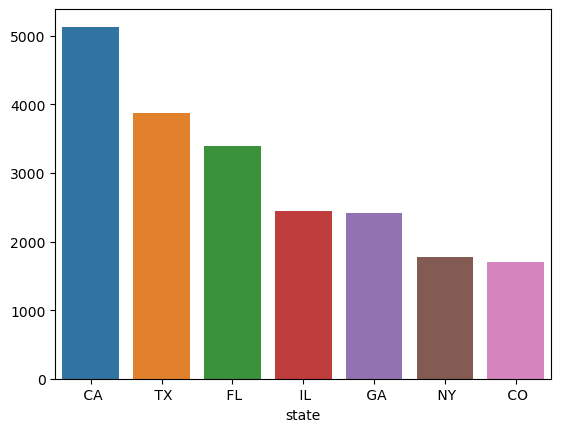

In [175]:
sns.barplot(x=top_7.index, y=top_7.values)
plt.show()

### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off? (distance)

In [22]:
df['distance_group'] = pd.qcut(df.distance, 3, labels=[0, 1, 2]) 

In [25]:
# df['hour'] = pd.qcut(df.crs_dep_time, 24, labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

ValueError: Bin edges must be unique: array([ 1.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [24]:
short = df[df['distance_group'] == 0]
mid = df[df['distance_group'] == 1]
long = df[df['distance_group'] == 2]

In [27]:
short = short.crs_dep_time.value_counts().sort_index()
mid = mid.crs_dep_time.value_counts().sort_index()
long = long.crs_dep_time.value_counts().sort_index()

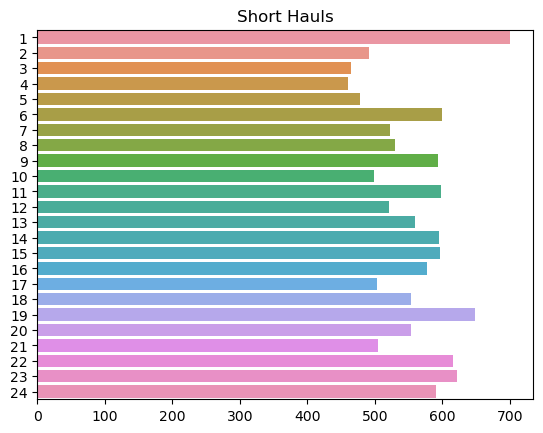

In [28]:
sns.barplot(short.values, short.index)
plt.title("Short Hauls")
plt.show()

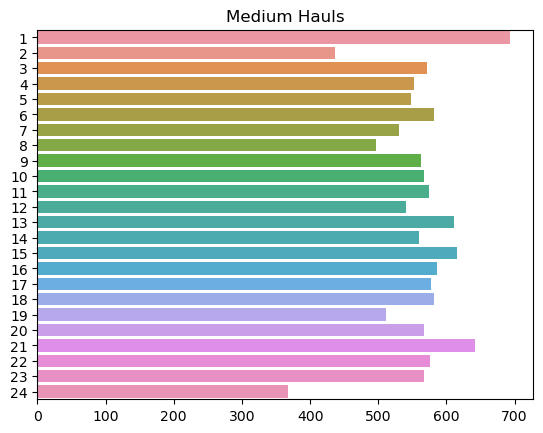

In [29]:
sns.barplot(mid.values, mid.index)
plt.title("Medium Hauls")
plt.show()

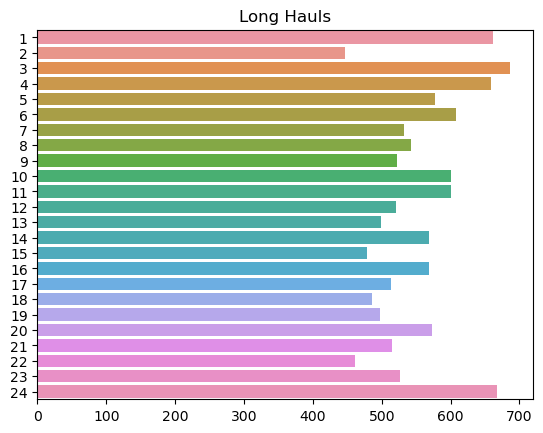

In [30]:
sns.barplot(long.values, long.index)
plt.title("Long Hauls")
plt.show()

#### **Task 9**: Find the top 10 most busy airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [193]:
top_10_busy = df.groupby(['origin_airport_id'], as_index=False).size().sort_values(by='size',ascending=False)[:12]

In [194]:
top_10_ids = [10397, 13930, 11292, 12892, 11298, 14771, 12889, 14107, 14747, 13487]

In [195]:
avg_pass = df.groupby('origin_airport_id', as_index=False).agg('avg_monthly_psngr_airport').sum().sort_values(by='avg_monthly_psngr_airport', ascending=False)[:12]

In [222]:
merge_10 = top_10_busy.merge(right=avg_pass, how='inner')

In [223]:
merge_10['avg_monthly_psngr_airport'] = round(merge_10['avg_monthly_psngr_airport'] / 10000000)

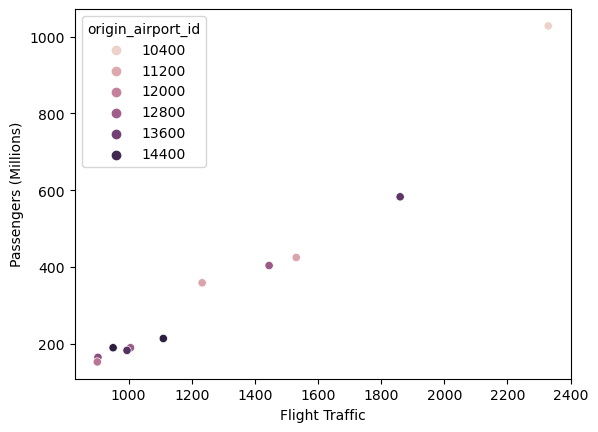

In [231]:
sns.scatterplot(x='size', y='avg_monthly_psngr_airport', hue='origin_airport_id', 
             data=merge_10)
sns.color_palette("rocket", as_cmap=True)
plt.title()
plt.xlabel('Flight Traffic')
plt.ylabel(f'Passengers (Millions)')
plt.show()

#### **Task 10**: Do bigger delays lead to bigger fuel consumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [336]:
agg_dict = {
    'arr_delay': 'mean',
    'distance': 'sum',
}

In [337]:
df_10 = delays.groupby(['carrier', 'month', 'avg_month_psngr_carrier', 'avg_domest_gallons_month_carrier'], as_index=False).agg(agg_dict)

In [338]:
df_10.rename(columns={'arr_delay': 'avg_monthly_delay_carrier',
                      'distance': 'Monthly_Distance',
                     }, inplace=True)

In [339]:
df_10.head(1)

,carrier,month,avg_month_psngr_carrier,avg_domest_gallons_month_carrier,avg_monthly_delay_carrier,Monthly_Distance
0,AA,1,5051.23237,174171571.0,15.265734,150906


In [340]:
df_10['avg_monthly_fuel_per_psnger'] =  df_10.avg_domest_gallons_month_carrier / df_10.avg_month_psngr_carrier

In [341]:
df_10.drop(['avg_domest_gallons_month_carrier', 'avg_month_psngr_carrier'], axis=1,inplace=True)

In [342]:
df_10['Monthly_Distance'] = pd.qcut(df_10.Monthly_Distance, 4, labels=['2k-20k', '20k-40k', '40k-100k', '100k+'])

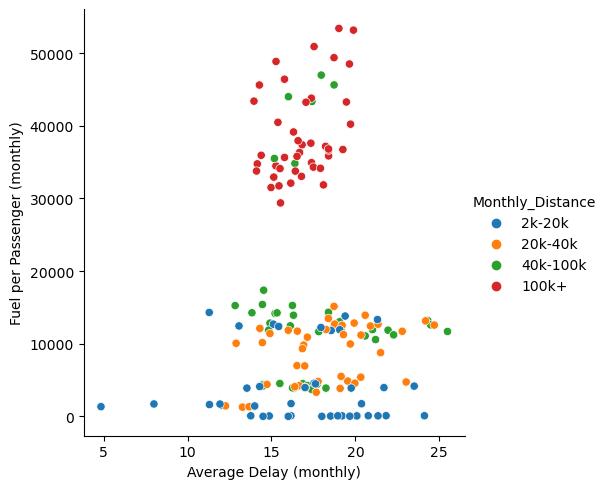

In [343]:
sns.relplot(x=df_10.avg_monthly_delay_carrier, y=df_10.avg_monthly_fuel_per_psnger, hue=df_10.Monthly_Distance)

plt.ylabel(f'Fuel per Passenger (monthly)')
plt.xlabel(f'Average Delay (monthly)')
plt.show()